![Time and attendance](images/timeattandance.png)

## Tabla de contenidos

#### Primeras operaciones
- Operaciones básicas sobre el dataset
- Primeras informaciones sobre las fechas
- Limpieza del dataset

#### Estádisticas sobre dispositivos
- Cantidad de registros por dispositivo
- Porcentaje de uso por tipo de autenticación
- Porcentaje de uso por tipo de autenticación por cada dispositivo
- El uso de métodos de autenticación sin contacto ha aumentado desde el comienzo de la pandemia?

#### Empleados y departamentos
- Número de empleados por departamento
- Creación de un dataset de empleados, incluyendo el género y los días trabajados dentro de la empresa
- Variación de empleados dentro de la empresa a lo largo del tiempo
- Porcentaje de empleados por género
- Variación de empleados a lo largo del tiempo por género
- Método de autenticación preferidos por los usuarios

#### Informaciones sobre los fichajes y las horas de trabajo
- Media número de fichajes y tiempo de trabajo de la empresa
- Limpieza de los outlier de los datos obtenidos
- Media tiempo de trabajo por departamento
- Media tiempo de trabajo de la empresa agrupada por meses

#### Otras estádisticas
- Correlación entre features categóricas

---

> ## Primeras operaciones

In [72]:
# Importamos las librerías necesarias
import pandas as pd
from os import path
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import pickle

#### Operaciones básicas sobre el dataset

In [73]:
# Importamos el dataset
workingPath = path.abspath('')
dataPath = path.join(workingPath, 'datasets', 'TimeAndAttandance_definitive.csv')                       
df = pd.read_csv(dataPath, encoding='1252')
df.sample(10, random_state=29)

,userID,name,datetime,deviceName,registryType,department,identificationCode
30123,77,Juan Jesus Rubio Montero,2018-12-17 13:16:46,Producción,Salida,Unidad B,8
38216,116,Raquel Carrillo Gomez,2018-06-25 13:26:29,Producción,Entrada,Planificación,1
53711,163,Anna Beltran Blanco,2019-12-17 13:26:50,Oficinas,Entrada,Administración,4
90801,445,Marta Molina Santiago,2020-07-30 13:01:24,Producción,Salida,Unidad A,1
83803,436,Maria Victoria Guillen Del Rio,2018-04-10 07:57:48,Producción,Entrada,Sillas Sin Astillas SA,1
77681,427,Maria Carmen Arias Alonso,2019-05-16 17:12:34,Almacén,Entrada,Unidad C,4
43885,136,Arnau Marin Lozano,2019-07-02 12:44:11,Oficinas,Entrada,Administración,1
49205,160,Irene Lara Alonso,2018-02-05 07:51:31,Producción,Entrada,Unidad A,8
18564,40,Leire Palacios Trujillo,2018-03-06 13:12:29,Almacén,Entrada,Unidad C,4
6347,14,Cristobal Manzano Galvez,2018-12-14 13:25:29,Producción,Entrada,Unidad B,8


In [74]:
# Defininimos un diccionario con las etiquetas de cada código de identificación
identificationCodes = {0: 'Manual',
                       1: 'Huella 1',
                       2: 'Huella 2',
                       4: 'PIN',
                       5: 'PIN + Huella 1',
                       8: 'RFID'}

In [75]:
# Informaciones sobre el dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109093 entries, 0 to 109092
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   userID              109093 non-null  int64 
 1   name                109093 non-null  object
 2   datetime            109093 non-null  object
 3   deviceName          106311 non-null  object
 4   registryType        109093 non-null  object
 5   department          109093 non-null  object
 6   identificationCode  109093 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 5.8+ MB


In [76]:
# Informaciones sobre el tamaño del dataframe
print(f'El dataset contiene {df.shape[0]} filas y {df.shape[1]} columnas')
print(f'Estas son las features y los tipos de datos:\n{df.dtypes}')

El dataset contiene 109093 filas y 7 columnas
Estas son las features y los tipos de datos:
userID                 int64
name                  object
datetime              object
deviceName            object
registryType          object
department            object
identificationCode     int64
dtype: object


#### Primeras informaciones sobre las fechas

In [77]:
# Transformamos las fechas a tipo datetime
df['datetime'] =  pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [78]:
# Fecha de inicio y final del dataset
start = df.datetime.min().strftime('%d de %B del %Y')
end = df.datetime.max().strftime('%d de %B del %Y')
print(f'El dataset tiene registros que van desde el {start} hasta el {end}')
# Contamos el número de días donde se tengan registros
uniqueDays = df['datetime'].dt.strftime("%d/%m/%Y").unique().tolist()
print(f'Tenemos en total {len(uniqueDays)} días útiles ', end='')
# Contamos todos los meses únicos del dataframe
uniqueMonths = sorted(df['datetime'].dt.strftime("%Y/%m").unique().tolist())
print(f'incluidos en {len(uniqueMonths)} meses únicos')

El dataset tiene registros que van desde el 02 de January del 2018 hasta el 31 de December del 2020
Tenemos en total 760 días útiles incluidos en 36 meses únicos


#### Limpieza del dataset

In [79]:
# Buscamos valores duplicados, aunque no debería haber
duplicateRows = df[df.duplicated()]
print(f'Hay {duplicateRows.shape[0]} filas duplicadas')

Hay 1233 filas duplicadas


Aunque no me lo esperaba, había elementos duplicados en el dataframe. Pensandolo bien he entendido porque ha pasado, por una mala programación por parte del instalador, que no ha configurado un tiempo minimo de espera entre un registro y otro.

In [80]:
# Eliminamos los elementos duplicados
df.drop_duplicates(inplace=True)

In [81]:
# Buscamos valores nulos aunque no debería haber
df.isnull().sum()

userID                   0
name                     0
datetime                 0
deviceName            2782
registryType             0
department               0
identificationCode       0
dtype: int64

Por lo visto hay valores nulos en el nombre de dispositivo. Evidentemente esos registros se han creado de manera manual y no desde un terminal.


In [82]:
# Rellenamos los campos nulos con el valor de la moda
moda = df.deviceName.mode()[0]
df['deviceName'].fillna(moda, inplace=True)

> ## Estadísticas sobre los dispositivos

In [83]:
# Analizamos lo valores únicos presentes en la feature deviceName
deviceRegistry = df.deviceName.value_counts()
devices = df.deviceName.unique()
print(f'Tenemos {len(devices)} dispositivos distintos: ', end='')
for i in range(len(devices)):
    if i == len(devices)-1:
        print(devices[i])
    elif i == len(devices)-2:
        print(devices[i], end=' y ')
    else:
        print(devices[i], end=', ')

Tenemos 3 dispositivos distintos: Producción, Oficinas y Almacén


#### Cantidad de registros por dispositivo

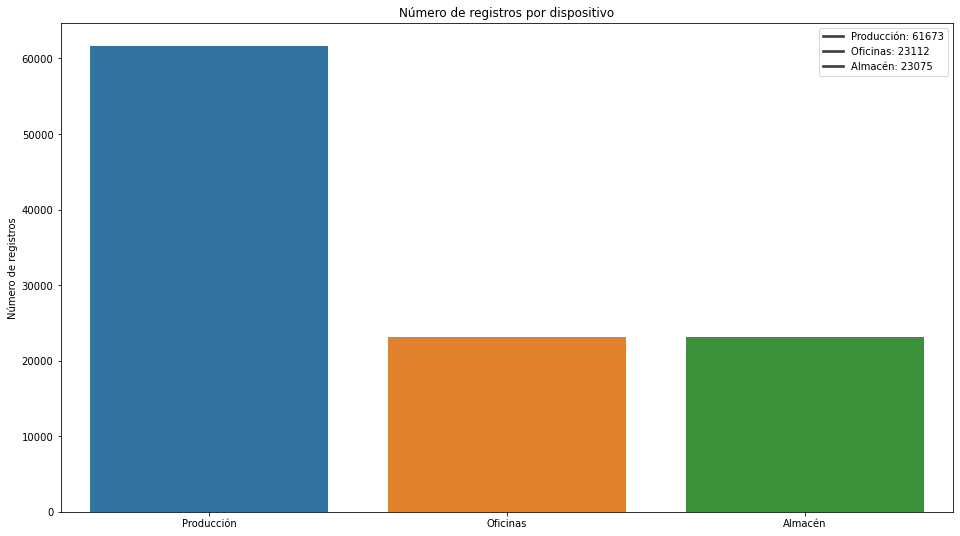

In [84]:
# Mostramos un gráfico de barras con los dispositivos y el número de registros que tienen
lbl = [f'{dev}: {reg}' for dev, reg in zip(devices, deviceRegistry)]
plt.figure(figsize=(16,9))
ax = sns.barplot(x=devices, y=deviceRegistry)
ax.set(ylabel='Número de registros', title='Número de registros por dispositivo')
ax.legend(lbl)
plt.show()

#### Porcentaje de uso por tipo de autenticación

In [85]:
def values_counter(dataframe, column, indexNames={}):
    '''
    Una función para calcular la frecuencia de los valores de una columna de
    un dataframe de Pandas

    Args:
        dataframe (pandas.dataframe): Un dataframe de Pandas
        column (str): El nombre de la columna a analizar
        indexNames (dict, optional): Un diccionario con los valores a reemplazar de los indices del dataframe final.

    Returns:
        pandas.dataframe: un dataframe con la frecuencia absoluta y la relativa
    '''
    countDF = dataframe[column].value_counts().to_frame()
    countDF['relative_%'] = round((countDF / countDF.sum()) * 100, 0)
    countDF.rename(columns={column:'count'}, inplace=True)
    if indexNames:
        countDF.rename(index=indexNames, inplace=True)
    return countDF

# Calculamos el porcentaje de uso por tipo de autenticación
identificationCount = values_counter(df, 'identificationCode', identificationCodes)
identificationCount

,count,relative_%
RFID,52049,48.0
Huella 1,30250,28.0
PIN,22030,20.0
Manual,2782,3.0
Huella 2,745,1.0
PIN + Huella 1,4,0.0


In [86]:
# Como los registros de tipo 2 (PIN + Huella) e 5 (Huella 2) son irrelevantes, los agrupamos con los del mismo grupo (Huella 1)
df.loc[(df['identificationCode'] == 2) | (df['identificationCode'] == 5), 'identificationCode'] = 1
identificationCount = values_counter(df, 'identificationCode', identificationCodes)

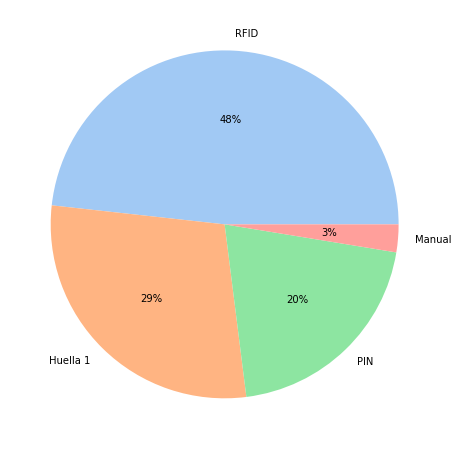

In [87]:
# Dibujamos gráfico
plt.figure(figsize=(8,8))
colors = sns.color_palette('pastel')
plt.pie(identificationCount['count'], labels = identificationCount.index, colors = colors, autopct='%.0f%%')
plt.show()

#### Porcentaje de uso por tipo de autenticación por cada dispositivo

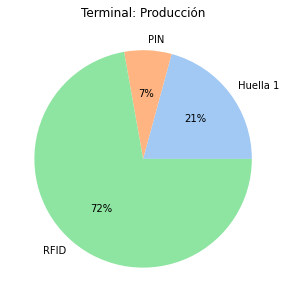

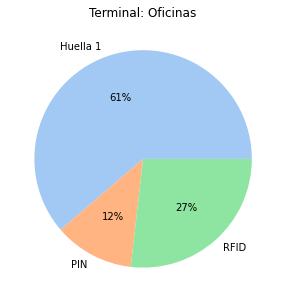

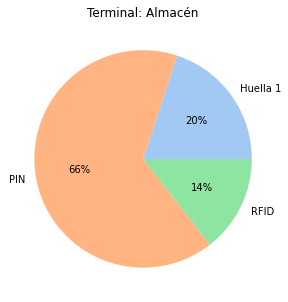

In [88]:
# Porcentaje de uso por tipo de autenticación por cada dispositivo
for device in devices:
    dfDevice = df[df.deviceName == device]
    dfDevice = dfDevice.drop(dfDevice[dfDevice.identificationCode == 0].index)
    deviceIdentCount = values_counter(dfDevice, 'identificationCode', identificationCodes).sort_index()
    plt.figure(figsize=(5,5))
    plt.title(f'Terminal: {device}')
    plt.pie(deviceIdentCount['count'], labels=deviceIdentCount.index, colors=colors, autopct='%.0f%%')
    plt.show()

#### El uso de métodos de autenticación sin contacto ha aumentado desde el comienzo de la pandemia?

In [89]:
def filter_by_unique_month(df, uniqueMonth, dateCol='datetime'):
    '''
    Una función para filtrar por un mes de un año en concreto dentro de un
    dataframe de Pandas

    Args:
        df (pandas.dataframe): Un daframe que tenga una columna de tipo datetime
        uniqueMonth (str): se indica el mes de año en el formato: 'YYYY/MM'
        dateCol (str): la columna de tipo datetime que usar por el filtrado 

    Returns:
       pandas.dataframe: un nuevo dataframe de Pandas filtrado por el mes dado
    '''
    startTime = '00:00:00'
    endTime = '23:59:59'
    # Creamos un diccionario con el número de días de cada mes
    monthDays = {'01': 31, '02': 28, '03': 31,
                 '04': 30, '05': 31, '06': 30,
                 '07': 31, '08': 31, '09': 30,
                 '10': 31, '11': 30, '12': 31}

    def leap_year(year):
        '''
        Una función para calcular si un año es bisiesto o no

        Args:
            year (int): El año a calcular en formato de 4 dígitos

        Returns:
            bool: True si es bisiesto, False si no lo es
        '''
        if year % 4 == 0 and year % 100 != 0 or year % 400 == 0:
            return True
        else:
            return False


    year, month = uniqueMonth.split('/')
    if month == '02' and leap_year(int(year)):
        day = 29
    else:
        day = monthDays[month]
    startDate = f'{year}-{month}-01 {startTime}'
    endDate = f'{year}-{month}-{day} {endTime}'
    return df.loc[(df[dateCol] >= startDate) & (df[dateCol] <= endDate)]


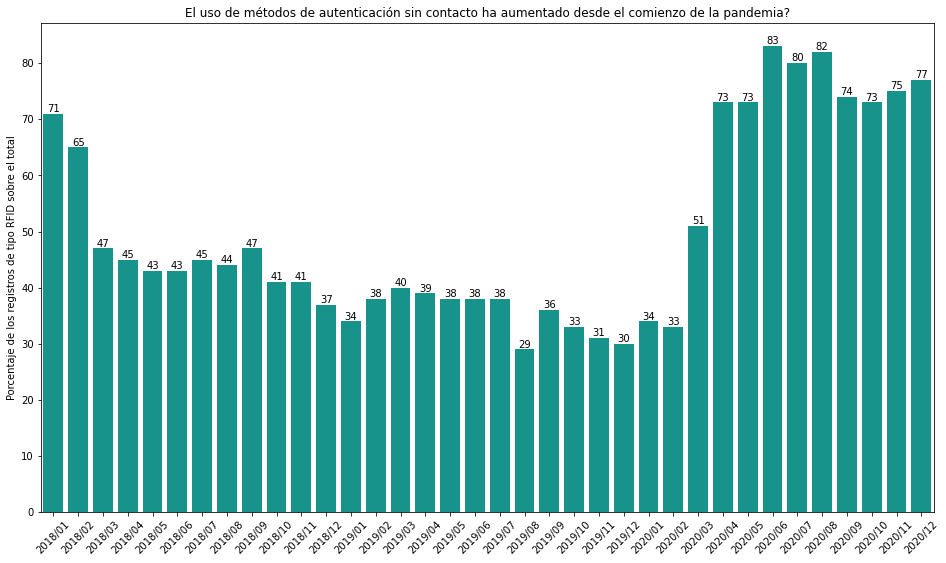

In [90]:
# Creamos una lista con los valores relativos sobre el total del uso de dispositivos sin contacto (RFID)
montlyRFIDrelative = []
for m in uniqueMonths:
    filteredDF = filter_by_unique_month(df, m)
    montlyRFIDrelative.append(values_counter(filteredDF, 'identificationCode', identificationCodes).loc['RFID']['relative_%'])

# Dibujamos el gráfico
plt.figure(figsize=(16, 9))
ax = sns.barplot(x=uniqueMonths, y=montlyRFIDrelative, color='#02A89D')
ax.set(ylabel='Porcentaje de los registros de tipo RFID sobre el total')
ax.set(title='El uso de métodos de autenticación sin contacto ha aumentado desde el comienzo de la pandemia?')
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 45)
plt.show()

> ## Empleados y departamentos

In [91]:
# Números de usuarios totales
totalEmployees = len(df.userID.unique())
print(f'Tenemos en todo el dataframe un total de {totalEmployees} empleados')

Tenemos en todo el dataframe un total de 123 empleados


In [92]:
# Departamentos
dep = df.department.unique()
print(f'En la empresa tenemos un total de {len(dep)} departamentos: ', end='')
for i in range(len(dep)):
    if i == len(dep)-1:
        print(dep[i])
    elif i == len(dep)-2:
        print(dep[i], end=' y ')
    else:
        print(dep[i], end=', ')

En la empresa tenemos un total de 7 departamentos: Sillas Sin Astillas SA, Administración, Unidad A, Unidad B, Unidad C, Dpto Técnico y Planificación


#### Número de empleados por departamento

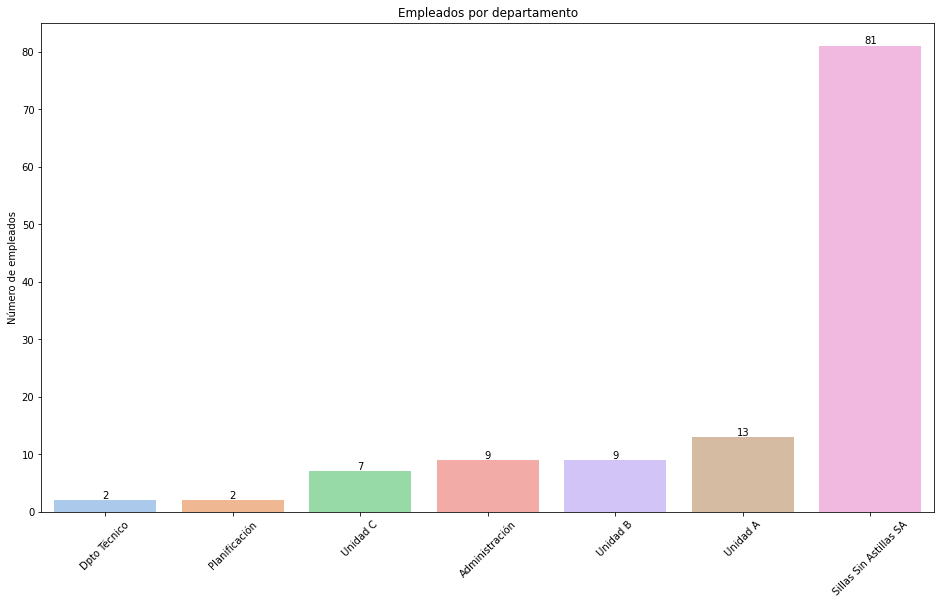

In [93]:
# Empleados por departamento
departmentDF = df.groupby('department').userID.unique()
d = {departmentDF.index[i]:len(elem) for i, elem in enumerate(departmentDF)}
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

# Dibujamos el gráfico
plt.figure(figsize=(16, 9))
ax = sns.barplot(x=list(d.keys()), y=list(d.values()), palette='pastel')
ax.set(ylabel='Número de empleados')
ax.set(title='Empleados por departamento')
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 45)
plt.show()


#### Creación de un dataset de empleados, incluyendo el género y los días trabajados dentro de la empresa
Creamos un nuevo dataset dedicado exclusivamente a los usuarios
En el dataset original no tenemos la información sobre el género de los empleados, sin embargo podemos averiguarlo a partir del nombre de los empleados.

In [94]:
# Si no existe ya, crea un diccionario con los nombres únicos
# dentro del dataframe y su género
namesDictFile = path.join(workingPath, 'tools', 'namesDict.p')
if path.isfile(namesDictFile):
    namesDict = pickle.load(open(namesDictFile, 'rb'))
else:
    from genderize import Genderize
    # Sacamos una lista de nombres únicos, seleccionando solo el primer nombre
    names = df['name'].unique()
    names = list(set([name.split()[0] for name in names]))
    # Agrupamos los nombres de diez en diez para hacer menos peticiones a la API
    names2 = []
    for n in range(0, len(names), 10):
        names2.append(names[n:n+10])
    # Hacemos peticiones a la api de genderize y guardamos los resultados en un diccionario
    namesDict = {}
    for block in names2:
        genders = Genderize().get(block)
        for p in genders:
            namesDict[p['name']] = p['gender']
    pickle.dump(namesDict, open(namesDictFile, 'wb'))

In [95]:
# Añadimos el genero de los empleados al dataset principal
gen = [namesDict[n[0]] for n in df['name'].str.split()]
df.insert(2, 'gender', gen)

In [96]:
# Creamos un dataframe vacío con las informaciones que nos interesan
employees = pd.DataFrame(columns=['userID', 'name', 'gender', 'department', 'workDays', 'firstDay', 'lastDay', 'prefDevice', 'prefIdentType'])
uniqueIDS = df['userID'].unique()
for i in uniqueIDS:
    newRow = {}
    filteredDF = df[df['userID'] == i].copy()
    filteredDF['datetime'] = filteredDF['datetime'].dt.date
    name = filteredDF['name'].iloc[0]
    department = filteredDF['department'].iloc[0]
    firstDay = filteredDF['datetime'].min()
    lastDay = filteredDF['datetime'].max()
    workDays = filteredDF['datetime'].nunique()
    prefDevice = filteredDF['deviceName'].mode()[0]
    prefIdentType = filteredDF['identificationCode'].mode()[0]
    newRow = {'userID':i,
              'name':name,
              'gender':namesDict[name.split()[0]],
              'department':department,
              'firstDay':firstDay,
              'lastDay':lastDay,
              'workDays':workDays,
              'prefDevice':prefDevice,
              'prefIdentType':identificationCodes[prefIdentType]}
    employees = employees.append(newRow, ignore_index=True)

employees['workDays'] = pd.to_numeric(employees['workDays'])
employees.sample(10, random_state=90)

,userID,name,gender,department,workDays,firstDay,lastDay,prefDevice,prefIdentType
60,453,Julen Montes Miranda,male,Sillas Sin Astillas SA,1,2018-12-10,2018-12-10,Producción,Huella 1
52,445,Marta Molina Santiago,female,Unidad A,507,2018-10-09,2020-12-31,Producción,Huella 1
122,522,Oscar Lorenzo Exposito,male,Unidad B,16,2020-12-04,2020-12-31,Producción,RFID
106,502,Ismael Bravo Carrasco,male,Sillas Sin Astillas SA,1,2019-11-15,2019-11-15,Producción,Huella 1
89,482,Petra Caballero Galan,female,Unidad B,255,2019-09-23,2020-12-31,Producción,PIN
16,107,Celia Vera Rivas,female,Unidad B,683,2018-01-02,2020-12-31,Producción,RFID
92,485,Alejandro Roca Lara,male,Sillas Sin Astillas SA,67,2019-10-02,2020-01-10,Producción,PIN
36,423,Alvaro Leon Ferrer,male,Unidad C,63,2020-09-28,2020-12-31,Almacén,RFID
61,454,Lorena Calvo Andres,female,Sillas Sin Astillas SA,133,2018-12-11,2019-06-28,Almacén,Huella 1
118,516,Angel Acosta Heredia,male,Sillas Sin Astillas SA,37,2020-02-10,2020-04-02,Almacén,PIN


#### Variación de empleados dentro de la empresa a lo largo del tiempo

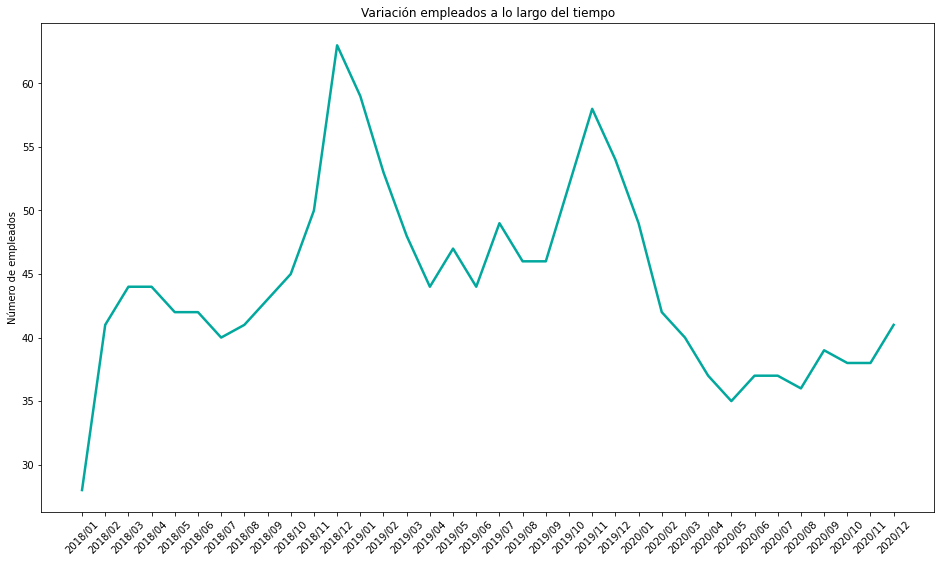

In [97]:
# Sacamos el número de empleados presentes en cada mes del dataset
employeesGrowing = {month:filter_by_unique_month(df, month).userID.nunique() for month in uniqueMonths}

# Dibujamos el gráfico
plt.figure(figsize=(16, 9))
ax = sns.lineplot(x=employeesGrowing.keys(), y=employeesGrowing.values(), color='#02A89D', linewidth=2.5)
ax.set(ylabel='Número de empleados')
ax.set(title='Variación empleados a lo largo del tiempo')
plt.xticks(rotation = 45)
plt.show()

#### Porcentaje de empleados por género

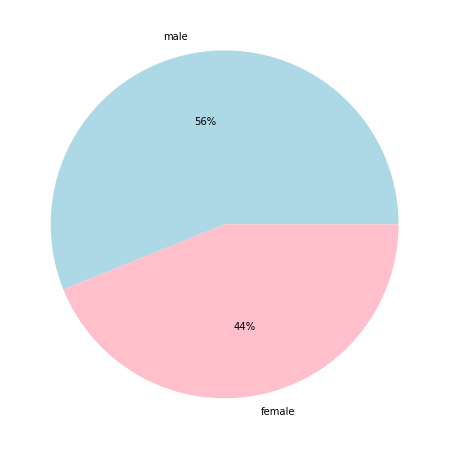

In [98]:
# Empleados por género
genderCount = values_counter(employees, 'gender')
# Dibujamos gráfico
plt.figure(figsize=(8,8))
colors = ['lightblue', 'pink']
plt.pie(genderCount['count'], labels = genderCount.index, colors = colors, autopct='%.0f%%')
plt.show()

#### Variación de empleados a lo largo del tiempo por género

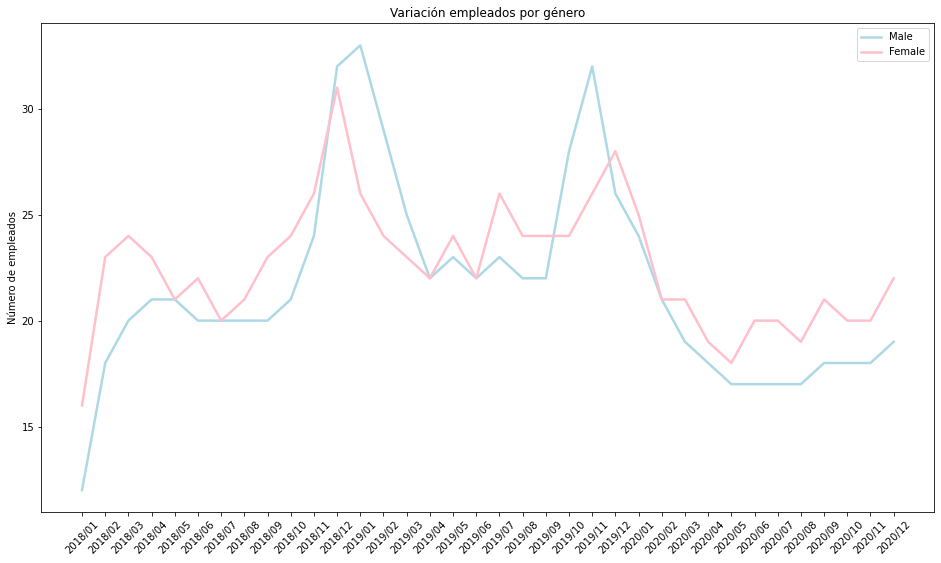

In [99]:
# Sacamos el número de empleados por género en cada mes del dataset
employeesGrowingMale = list()
employeesGrowingFemale = list()
for month in uniqueMonths:
    montlyUsers = filter_by_unique_month(df, month).userID.unique()
    maleUsers = femaleUsers = 0
    for user in montlyUsers:
        gender = employees[employees.userID == user].gender.iloc[0]
        if gender == 'male':
            maleUsers += 1
        else:
            femaleUsers += 1
    employeesGrowingMale.append(maleUsers)
    employeesGrowingFemale.append(femaleUsers)

# Dibujamos el gráfico
plt.figure(figsize=(16, 9))
ax = sns.lineplot(x=uniqueMonths, y=employeesGrowingMale, color='lightblue', linewidth=2.5)
ax = sns.lineplot(x=uniqueMonths, y=employeesGrowingFemale, color='pink', linewidth=2.5)
ax.set(ylabel='Número de empleados')
ax.set(title='Variación empleados por género')
ax.legend(['Male', 'Female'])
plt.xticks(rotation = 45)
plt.show()

#### Método de autenticación preferidos por los usuarios

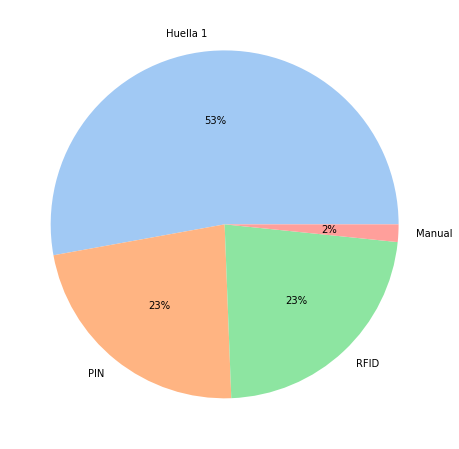

In [100]:
# Método de autenticación preferidos por los usuarios
deviceCount = values_counter(employees, 'prefIdentType')
# Dibujamos gráfico
plt.figure(figsize=(8,8))
colors = sns.color_palette('pastel')
plt.pie(deviceCount['count'], labels = deviceCount.index, colors = colors, autopct='%.0f%%')
plt.show()

> ## Informaciones sobre los fichajes y las horas de trabajo

#### Media número de fichajes y tiempo de trabajo de la empresa

In [101]:
# Empleado que menos ha trabajado en la empresa
minWorkDays = employees[employees.workDays == employees.workDays.min()]
print(f'El empleado que menos ha trabajado en la empresa es {minWorkDays.name.iloc[0]} con {minWorkDays.workDays.iloc[0]}', 'días trabajados' if minWorkDays.workDays.iloc[0] > 1 else 'día trabajado')

# Empleado que más ha trabajado en la empresa
maxWorkDays = employees[employees.workDays == employees.workDays.max()]
print(f'El empleado que más antiguedad tiene en la empresa desde que se tienen registros es {maxWorkDays.name.iloc[0]} con {maxWorkDays.workDays.iloc[0]} días trabajados')

El empleado que menos ha trabajado en la empresa es Julen Montes Miranda con 1 día trabajado
El empleado que más antiguedad tiene en la empresa desde que se tienen registros es Irene Lara Alonso con 690 días trabajados


In [102]:
# Calculos sobre el tiempo
# En éste bloque de código vamos a sacar disitintas informaciones:
# regPerDay: el número de veces que se repite que un usuario ha fichado x veces 
# mediaRegsPorUsuario: la media de fichajes díarios por cada empleado
# mediaHorasPorUsuario: la media de horas diarias trabajadas para cada empleado

# Filtrar por usuario
regPerDay = {}
mediaRegsPorUsuario = {}
mediaHorasPorUsuario = {}
usersID = df.userID.unique()
startTime = '00:00:00'
endTime = '23:59:59'
for userID in usersID:
    registrosDiariosUsuario = []
    horasDiariasUsuario = []
    userDF = df[df.userID == userID]
    daysList = [str(d) for d in userDF['datetime'].dt.date.unique()]
    # Filtrar por día
    for day in daysList:
        dayDF = userDF.loc[(userDF['datetime'] >= f'{day} {startTime}') & (userDF['datetime'] <= f'{day} {endTime}')]
        horasDiariasUsuario.append(dayDF.datetime.iloc[-1] - dayDF.datetime.iloc[0])
        registrosDiariosUsuario.append(dayDF.shape[0])
        regs = dayDF.shape[0]
        try:
            regPerDay[regs] += 1
        except KeyError:
            regPerDay[regs] = 1
    mediaRegsPorUsuario[userDF['name'].iloc[0]] = sum(registrosDiariosUsuario)/len(registrosDiariosUsuario)
    mediaHorasPorUsuario[userDF['name'].iloc[0]] = (sum(horasDiariasUsuario, datetime.timedelta())/len(horasDiariasUsuario)).seconds//60

In [103]:
# def timedelta_to_hours(tdObject, clockTime=False):
#     seconds = tdObject.seconds
#     hours = seconds//3600
#     minutes = (seconds//60)%60
#     seconds = seconds%60
#     if clockTime:
#         return f'{hours:02d}:{minutes:02d}:{seconds:02d}'
#     else:
#         return hours, minutes, seconds

def minutes_to_hours(m):
    '''
    Una función que devuelve una tupla con las horas y minutos a partir de los minutos

    Args:
        m (int): los minutos a convertir

    Returns:
        tuple: una tupla con dos enteros, las horas y los minutos
    '''
    h = int(m // 60)
    m = int(round(m % 60, 0))
    return h, m

In [104]:
# Añadimos la media de cada usuario al dataframe de los empleados
employees['workedHoursMean'] = [f'{minutes_to_hours(mediaHorasPorUsuario[name])[0]:02d}:{minutes_to_hours(mediaHorasPorUsuario[name])[1]:02d}' for name in employees.name]
employees['workedMinutesMean'] = [mediaHorasPorUsuario[name] for name in employees.name]

#### Buscamos y eliminamos los outlier

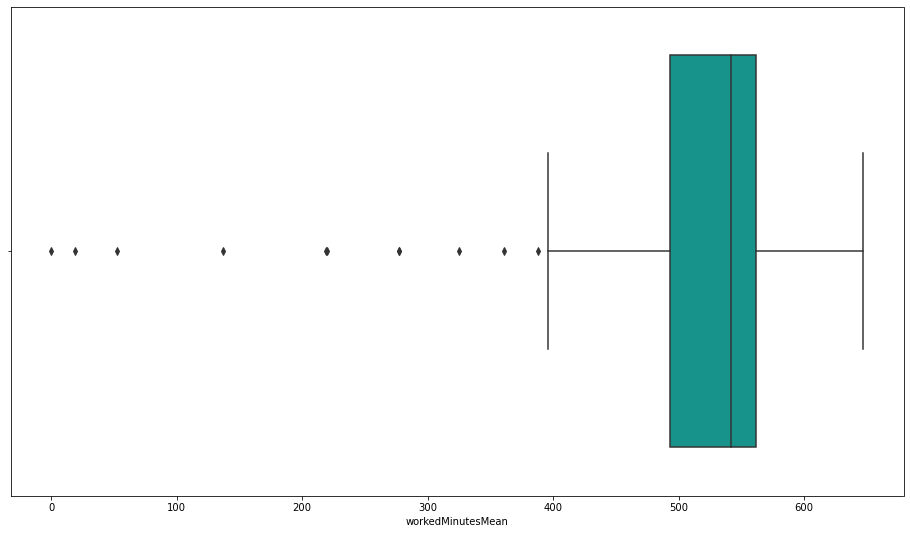

In [105]:
plt.figure(figsize=(16,9))
sns.boxplot(x=employees['workedMinutesMean'], color='#02A89D')
plt.show()

In [106]:
# En éste caso NO usamos el metodo del rango intercuartílico, sino que eliminamos aquellos empleados que hayan trabajado
# de media menos que 240 minutos (4 horas)
# Lo haremos tanto en el dataset de los empleados como en el principal
dfShapePreOutlierClean = df.shape[0]
minutosMinimosJornadaLaboral = 240
usuariosAeliminar = employees[employees.workedMinutesMean < minutosMinimosJornadaLaboral]['userID'].unique()
for u in usuariosAeliminar:
    employees = employees.drop(employees[employees.userID == u].index)
    df = df.drop(df[df.userID == u].index)
print(f'Se han eliminado {dfShapePreOutlierClean - df.shape[0]} registros de {len(usuariosAeliminar)} empleados que en media han trabajado menos de {minutosMinimosJornadaLaboral} minutos al día')

Se han eliminado 77 registros de 6 empleados que en media han trabajado menos de 240 minutos al día


In [107]:
employees.describe()

,workDays,workedMinutesMean
count,117.000000,117.000000
mean,230.598291,525.188034
std,254.381707,64.118012
min,1.000000,277.000000
25%,25.000000,502.000000
50%,85.000000,545.000000
75%,482.000000,562.000000
max,690.000000,647.000000


In [108]:
# Media de fichajes 
mediaRegistrosDiariosPorUsuario = round(sum(mediaRegsPorUsuario.values())/len(mediaRegsPorUsuario), 2)
print(f'En media cada usuario de la empresa ficha {mediaRegistrosDiariosPorUsuario} veces al día')

# Moda de número de fichajes diarios
key_list = list(regPerDay.keys())
val_list = list(regPerDay.values())
m = max(val_list)
position = val_list.index(m)
n = key_list[position]
print(f'El caso más común es que cada usuario fiche {n} veces al día')

# Media horas trabajadas
mediaHorasEmpresa = minutes_to_hours(employees.workedMinutesMean.mean())
print(f'En media la jornada laboral dura {mediaHorasEmpresa[0]} horas y {mediaHorasEmpresa[1]} minutos')

En media cada usuario de la empresa ficha 3.8 veces al día
El caso más común es que cada usuario fiche 4 veces al día
En media la jornada laboral dura 8 horas y 45 minutos


#### Media tiempo de trabajo por departamento

In [109]:
departments = sorted(employees.department.unique())
mediasHorasDepartamento = {}
for d in departments:
    mediaDepartamento = []
    tempDF = employees[employees.department == d]
    users = tempDF.name.unique()
    for u in users:
        mediaDepartamento.append(mediaHorasPorUsuario[u])
    media = sum(mediaDepartamento) / len(mediaDepartamento)
    mediasHorasDepartamento[d] = media

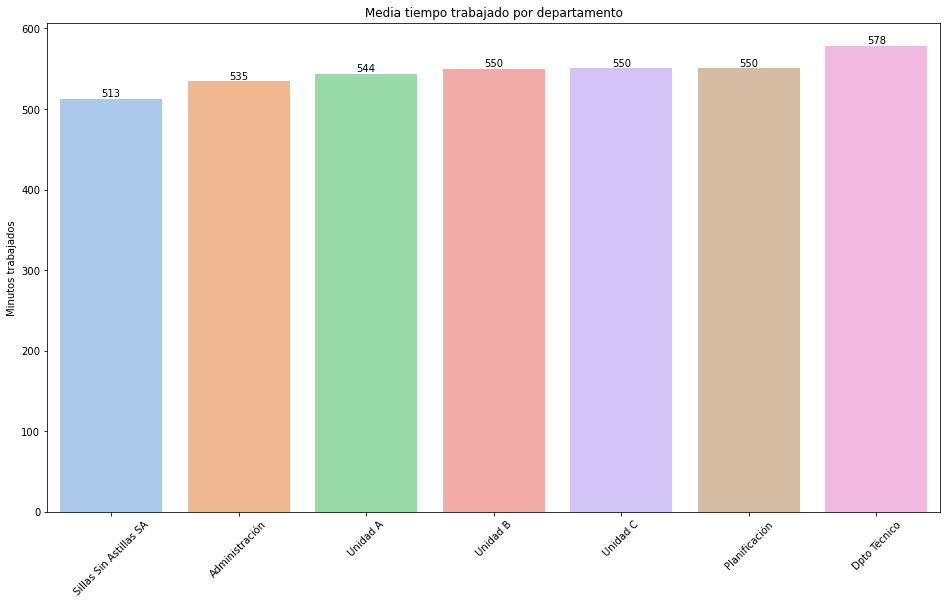

In [110]:
# Dibujamos grafico
mediasHorasDepartamento = {k: v for k, v in sorted(mediasHorasDepartamento.items(), key=lambda item: item[1])}
plt.figure(figsize=(16, 9))
ax = sns.barplot(x=list(mediasHorasDepartamento.keys()), y=list(mediasHorasDepartamento.values()), palette='pastel') 
ax.set(ylabel='Minutos trabajados')
ax.set(title='Media tiempo trabajado por departamento')
ax.bar_label(ax.containers[0], labels=[int(round(m, 0)) for m in mediasHorasDepartamento.values()])
plt.xticks(rotation = 45)
plt.show()

#### Media tiempo de trabajo de la empresa agrupada por meses

In [111]:
# Filtrar por meses
mediaTodosLosMeses = {}
for month in uniqueMonths:
    monthDF = filter_by_unique_month(df, month)
    usersID = monthDF.userID.unique()
    mediaMes = []
    # Filtrar por usuario
    for userID in usersID:
        horasDiariasUsuario = []
        userDF = monthDF[monthDF.userID == userID]
        daysList = [str(d) for d in userDF['datetime'].dt.date.unique()]
        # Filtrar por día
        for day in daysList:
            dayDF = userDF.loc[(userDF['datetime'] >= f'{day} {startTime}') & (userDF['datetime'] <= f'{day} {endTime}')]
            horasDiariasUsuario.append(dayDF.datetime.iloc[-1] - dayDF.datetime.iloc[0])
        mediaUsuarioMes = sum(horasDiariasUsuario, datetime.timedelta()) / len(horasDiariasUsuario)
        mediaMes.append(mediaUsuarioMes)
    mediaTodosLosMeses[month] = round((sum(mediaMes, datetime.timedelta()) / len(mediaMes)).seconds/60, 0)

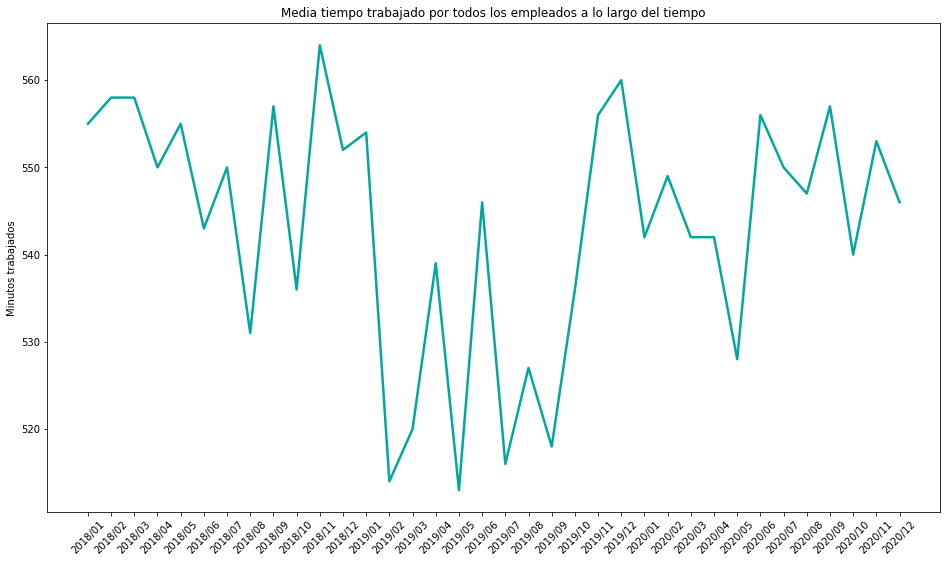

In [112]:
# Dibujamos el gráfico
plt.figure(figsize=(16, 9))
ax = sns.lineplot(x=mediaTodosLosMeses.keys(), y=mediaTodosLosMeses.values(), color='#02A89D', linewidth=2.5)
ax.set(ylabel='Minutos trabajados')
ax.set(title='Media tiempo trabajado por todos los empleados a lo largo del tiempo')
plt.xticks(rotation = 45)
plt.show()

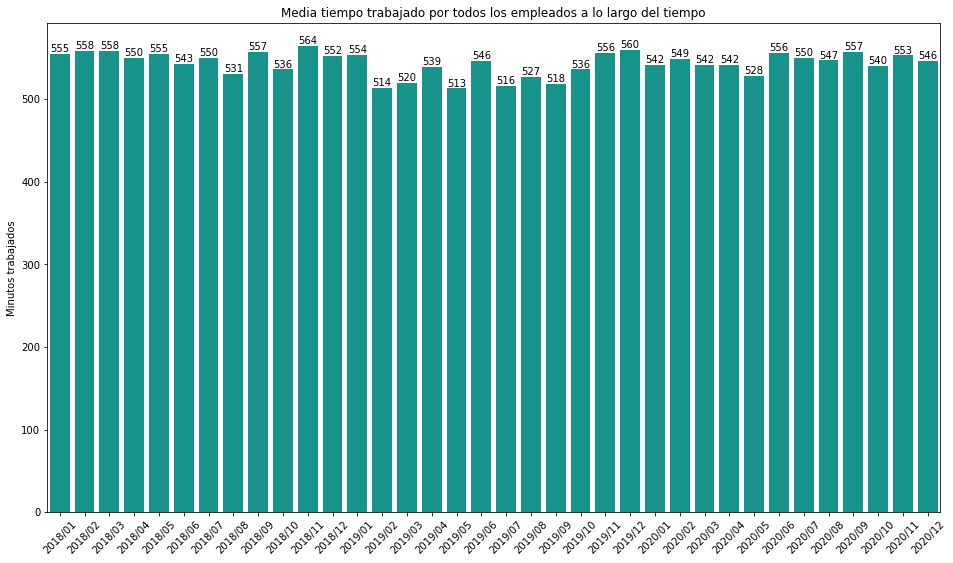

In [113]:
# Dibujamos el gráfico
y = list(mediaTodosLosMeses.values())
plt.figure(figsize=(16, 9))
ax = sns.barplot(x=uniqueMonths, y=y, color='#02A89D')
ax.set(ylabel='Minutos trabajados')
ax.set(title='Media tiempo trabajado por todos los empleados a lo largo del tiempo')
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 45)
plt.show()

> ## Otras estádisticas

#### Correlación entre features categóricas

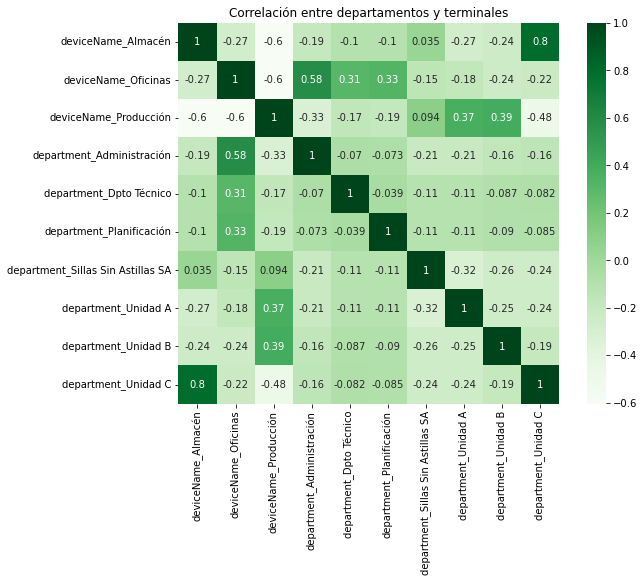

In [114]:
# Correlación entre departamentos y terminales
dummies = pd.get_dummies(df[['deviceName', 'department']])
corr = dummies.corr()
plt.figure(figsize=(10, 7))
ax = sns.heatmap(corr, cmap="Greens", square=True, annot=True)
ax.set(title='Correlación entre departamentos y terminales')
plt.show()

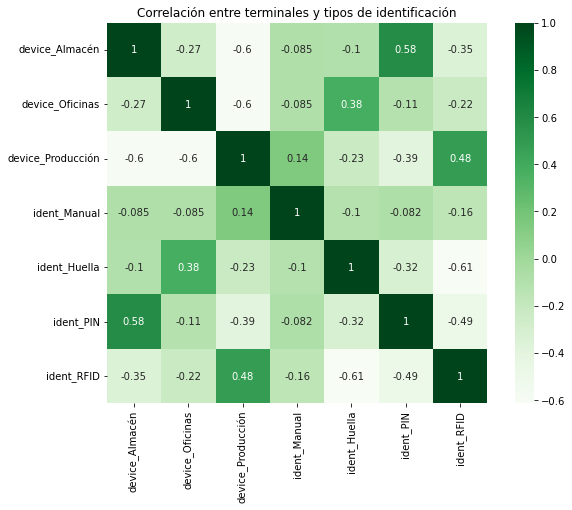

In [115]:
# Correlación entre terminales y tipos de identificación
df['identificationCode'] = df['identificationCode'].astype(str)
dummies = pd.get_dummies(df[['deviceName', 'identificationCode']])
dummies.columns = ['device_Almacén', 'device_Oficinas', 'device_Producción',
                   'ident_Manual', 'ident_Huella', 'ident_PIN', 'ident_RFID']
corr = dummies.corr()
plt.figure(figsize=(10, 7))
ax = sns.heatmap(corr, cmap="Greens", square=True, annot=True)
ax.set(title='Correlación entre terminales y tipos de identificación')
plt.show()